In [1]:
from ngsolve import *
from netgen.geom2d import SplineGeometry
from ngsolve.webgui import Draw
import matplotlib.pyplot as plt

importing NGSolve-6.2.2204


setup geometry

In [2]:
geo = SplineGeometry()
h_coarse = 0.6
h_fine = 0.5
geo.AddRectangle( (-3,-2), (3, 2), bcs = ("top", "out", "bot", "in"), leftdomain=1, rightdomain=0, maxh=h_coarse) 
geo.AddCircle(c=(0, 0), r=1, leftdomain=2, rightdomain=1, bc="outer_cylinder", maxh=h_fine) 
geo.AddCircle(c=(0, 0), r=0.5, leftdomain=0, rightdomain=2, bc="cyl", maxh=h_fine) 
#geo.SetDomainMaxH(2, 0.08)
mesh = Mesh(geo.GenerateMesh(maxh=h_coarse))
mesh.Curve(2);

geo_1 = SplineGeometry()
geo_1.AddRectangle((0,0),(1,1))
mesh_1 = Mesh(geo_1.GenerateMesh())
Draw(mesh)

WebGuiWidget(value={'gui_settings': {}, 'ngsolve_version': '6.2.2204', 'mesh_dim': 2, 'order2d': 2, 'order3d':…

BaseWebGuiScene

setup FEM space

In [3]:
# Order of spaces
k = 2
# H1 vs VectorH1 -> vector field?!
V = H1(mesh,order=k, dirichlet="top|bot|cyl|in|out")
Q = H1(mesh,order=k-1)
FES = FESpace([V,V,Q]) # [V,Q] (without VectorH1)

setup bilinear form
velocityfield u and pressurefield p

In [4]:
ux,uy,p = FES.TrialFunction()
vx,vy,q = FES.TestFunction()

# stokes equation
def Equation(ux,uy,p,vx,vy,q):
    div_u = grad(ux)[0]+grad(uy)[1] # custom div
    div_v = grad(vx)[0]+grad(vy)[1]
    return (grad(ux)*grad(vx)+grad(uy)*grad(vy) + div_u*q + div_v*p).Compile() * dx


# (InnerProduct(grad(u),grad(v))+div(u)*q+div(v)*p)*dx
a = BilinearForm(FES)
a += Equation(ux,uy,p,vx,vy,q)
a.Assemble()

setup boundary conditions

In [5]:
gfu = GridFunction(FES)
uinf = 0.001
uin = CoefficientFunction((uinf))
gfu.components[0].Set(uin, definedon=mesh.Boundaries("in|top|bot|out"))

x_velocity = CoefficientFunction(gfu.components[0])
scene_state = Draw(x_velocity, mesh, "vel")

WebGuiWidget(value={'gui_settings': {}, 'ngsolve_version': '6.2.2204', 'mesh_dim': 2, 'order2d': 2, 'order3d':…

solve stokes

In [6]:
def solveStokes():
    res = gfu.vec.CreateVector()
    res.data = -a.mat * gfu.vec
    inv = a.mat.Inverse(FES.FreeDofs())
    gfu.vec.data += inv * res
    scene_state.Redraw()
solveStokes()

# Calculations/Setup for all the side constraints

Drag/ "dissipated energy" [should be working]

$J(\Omega ) = \frac{1}{2} \int_\Omega Du : Du dx$ 

In [7]:
def calc_drag(gfu):
    ux = gfu.components[0]
    uy = gfu.components[1]
    return 0.5*(grad(ux)*grad(ux)+grad(uy)*grad(uy)).Compile()*dx

### get surface area of mesh (main issue)
$vol(\Omega) = \int_{\Omega} 1 \,dx \in \mathbb{R}$ should stay constant <br>
entire area: $A = 6*4=24$ <br>
$\alpha\Big(\mathrm{Vol}(\Omega(s))-\mathrm{Vol}(\Omega_0)\Big)^2$

In [8]:
alpha = 1e-4
surf_t = CoefficientFunction(1)
surf_0 = Integrate(surf_t,mesh)

def calc_surf_change():
    return alpha*(surf_t*dx-surf_0)**2

### barycenter (not necessarily useful yet)
$bc^\Omega = \frac{1}{vol(\Omega)}\int_{\Omega}x\,dx \in \mathbb{R}^d$ for each dimension!!

In [9]:
bc_tx = CoefficientFunction(x)
bc_ty = CoefficientFunction(y)
bc_0x = 1/surf_0*Integrate(bc_tx,mesh)
bc_0y = 1/surf_0*Integrate(bc_ty,mesh)

In [10]:
def Cost(gfu):
    return calc_drag(gfu) + calc_surf_change()# + calc_bc_change()

# creation of Shapediff Space + pertubation Function
function that will perturb our mesh

In [11]:
# Test and trial functions for shape derivate -> do we even need this?
VEC = H1(mesh, order=2, dim=2, dirichlet="top|bot|in|out")
PHI, X = VEC.TnT()
# gfset denotes the deformation of the original domain and will be updated during the shape optimization
gfset = GridFunction(VEC)
gfset.Set((0,0))
mesh.SetDeformation(gfset)
SetVisualization (deformation=True)

# deformation calculation
gfX = GridFunction(VEC)

# Shape Optimization
$\min_{h,u,s} \int_{\Omega(s)} \sum_{i,j=1}^2 \left( \frac{\partial u_i}{\partial x_j}\right)^2~\mathrm{d} x
 + \alpha\Big(\mathrm{Vol}(\Omega(s))-\mathrm{Vol}(\Omega_0)\Big)^2
+ \beta\sum_{j=1}^2 \Big(\mathrm{Bc}_j(\Omega(s))-\mathrm{Bc}_j(\Omega_0)\Big)^2,$

$\frac{1}{2} \int_\Omega Du : Du dx + \alpha\Big(\mathrm{Vol}(\Omega(s))-\mathrm{Vol}(\Omega_0)\Big)^2
+ \beta\sum_{j=1}^2 \Big(\mathrm{Bc}_j(\Omega(s)) - \mathrm{Bc}_j(\Omega_0)\Big)^2,$ (1)

In [12]:
ux = gfu.components[0]
uy = gfu.components[1]
p = gfu.components[2]

vol = Parameter(1)
vol.Set(Integrate(surf_t,mesh))

Lagrangian = Equation(ux,uy,p,ux,uy,p) + calc_drag(gfu) #  

In [13]:
dJOmega = LinearForm(VEC)
dJOmega += Lagrangian.DiffShape(X)

# volume side constraint
vol = Parameter(1)
vol.Set(Integrate(surf_t,mesh))
alpha0 = 1e-4
alpha = Parameter(alpha0)
#dJOmega += ((2*alpha*((vol-surf_0))*vol)*dx).DiffShape(X).Compile().DiffShape(X) # (definedon="mesh_1")
dJOmega += 2*alpha*(vol-surf_0)*div(X)*dx

# barycenter x sideconstraint
beta0 = 1e-3
beta = Parameter(beta0)
bc_x = Parameter(1)
bc_x.Set((1/surf_0)*Integrate(bc_tx,mesh))
dJOmega += ((beta*((bc_x-bc_0x)**2)*dx)).Compile().DiffShape(X)

# barycenter y sideconstraint
bc_y = Parameter(1)
bc_y.Set((1/surf_0)*Integrate(bc_ty,mesh))
dJOmega += ((beta*((bc_y-bc_0y)**2)*dx)).Compile().DiffShape(X)

b = BilinearForm(VEC)
b += (InnerProduct(grad(X),grad(PHI))).Compile() *dx + (InnerProduct(X,PHI)).Compile()*dx

# Cauchy-Riemann Penalisation
gamma = 3
b += gamma*(PHI.Deriv()[0,0] - PHI.Deriv()[1,1])*(X.Deriv()[0,0] - X.Deriv()[1,1])*dx
b += gamma*(PHI.Deriv()[1,0] - PHI.Deriv()[0,1])*(X.Deriv()[1,0] - X.Deriv()[0,1])*dx

In [14]:
def updateParams(v=False):
    vol.Set(Integrate(surf_t,mesh))
    bc_x.Set((1/surf_0)*Integrate(bc_tx,mesh))
    bc_y.Set((1/surf_0)*Integrate(bc_ty,mesh))
    if(v):
        print(vol.Get(), bc_x.Get(), bc_y.Get())
updateParams()

def increaseParams(k=2,v=False):
    alpha.Set(alpha.Get()*k)
    beta.Set(beta.Get()*k)
    if(v):
        print("alpha: ", alpha.Get(), ", beta: ", beta.Get())

In [15]:
def SolveDeformationEquation():
    rhs = gfX.vec.CreateVector()
    rhs.data = dJOmega.vec - b.mat * gfX.vec
    update = gfX.vec.CreateVector()
    update.data = b.mat.Inverse(VEC.FreeDofs()) * rhs
    gfX.vec.data += update

In [16]:
scene = Draw(gfset)

WebGuiWidget(value={'gui_settings': {}, 'ngsolve_version': '6.2.2204', 'mesh_dim': 2, 'order2d': 2, 'order3d':…

# Iterations done properly

In [17]:
gfset.Set((0,0))
mesh.SetDeformation(gfset)
scene.Redraw()

updateParams()
alpha0 = 1e-4
beta0 = 0
alpha.Set(alpha0)
beta.Set(beta0)

a.Assemble()
solveStokes()

data = [[] for x in range(7)]

iter_max = 50
Jold = Integrate(calc_drag(gfu), mesh)

# try parts of loop
mesh.SetDeformation(gfset)
scene.Redraw()

# input("Press enter to start optimization")
for i in range(0,iter_max):
    mesh.SetDeformation(gfset)
    scene.Redraw()
    scene_state.Redraw()
    
    if i%50 == 0:
        print('drag at iteration', i, ': ', Jold)
        
    titles = ["drag","volume","bc_x","bc_y","scale","gfxnorm","gfxbndnorm"] # collecting data
    data[0].append(Integrate(calc_drag(gfu),mesh))
    data[1].append(vol.Get())
    data[2].append(bc_x.Get())
    data[3].append(bc_y.Get())
    
    a.Assemble()
    solveStokes()
    
    b.Assemble()
    dJOmega.Assemble()
    SolveDeformationEquation()
    updateParams()
    
    Jnew = Integrate(calc_drag(gfu), mesh)
    mesh.UnsetDeformation()
    
    gfxnorm = Norm(gfX.vec)
    gfxbndnorm = Norm(Integrate(gfX,mesh,BND))
    data[6].append(gfxbndnorm)
    #scale = 0.1 / Norm(gfX.vec)
    scale = 0.01 / gfxnorm
    data[4].append(scale)
    jdiff = abs(Jnew-Jold)
    data[5].append(gfxnorm)
    
    if(gfxnorm < 1e-5):
        if alpha.Get() < 1:
            increaseParams(2,True)
        else:
            print("alpha too big")
            break
            
    gfsetOld = gfset
    gfset.vec.data -= scale * gfX.vec
    Jold = Jnew

    Redraw(blocking=True)

drag at iteration 0 :  1.101252184865718e-05


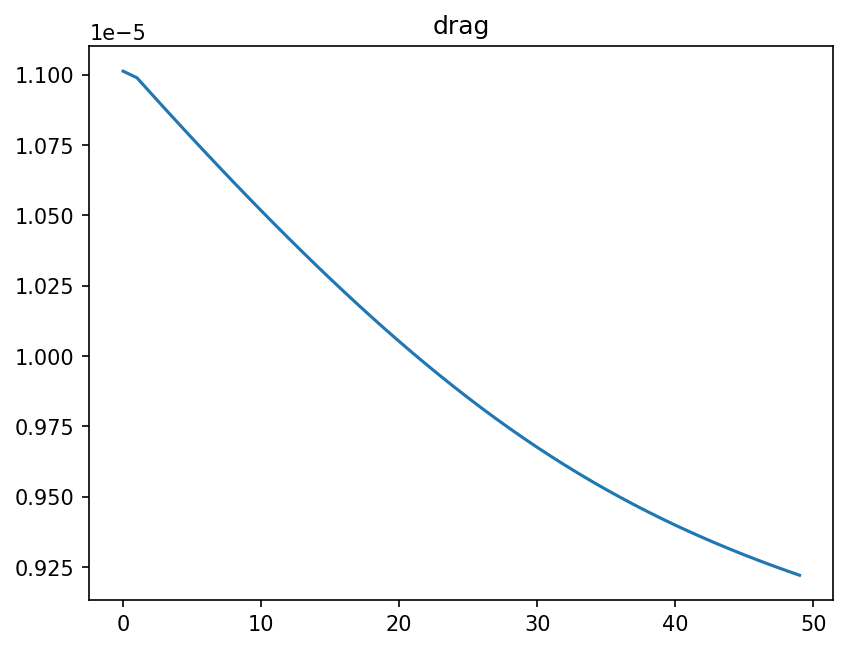

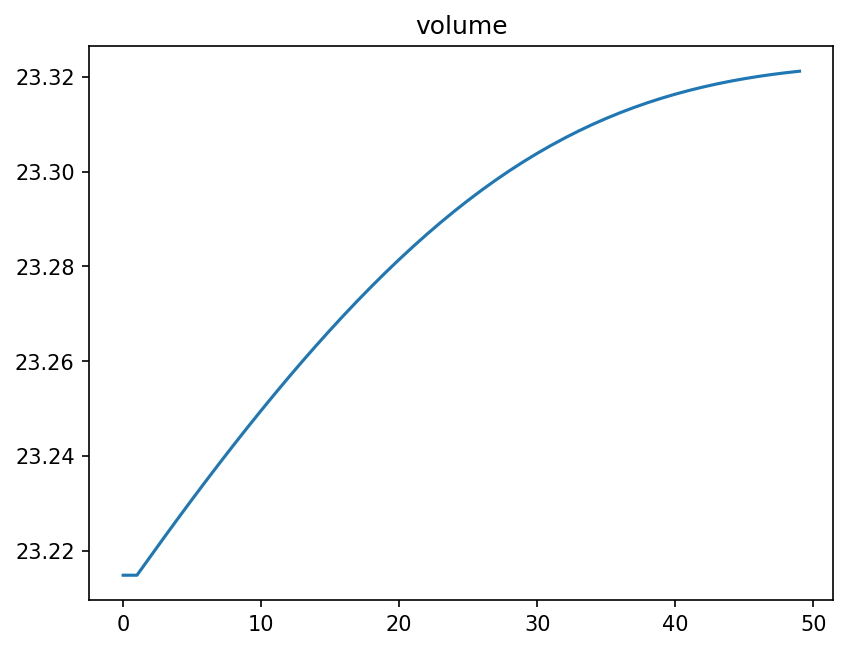

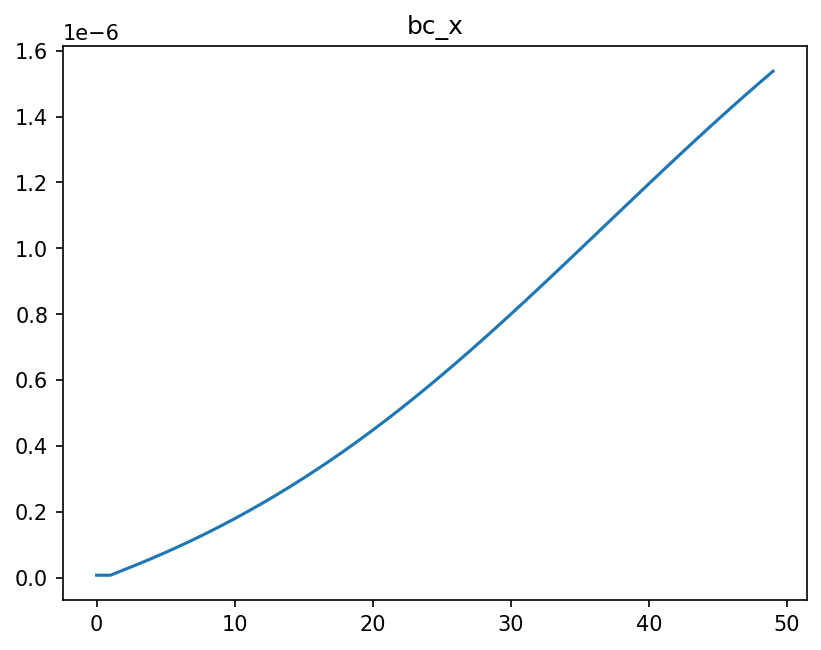

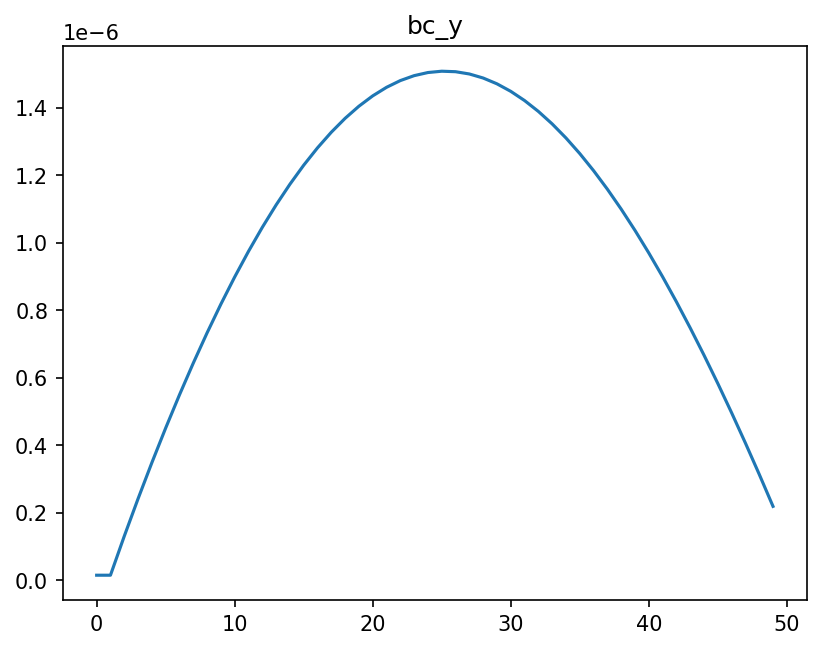

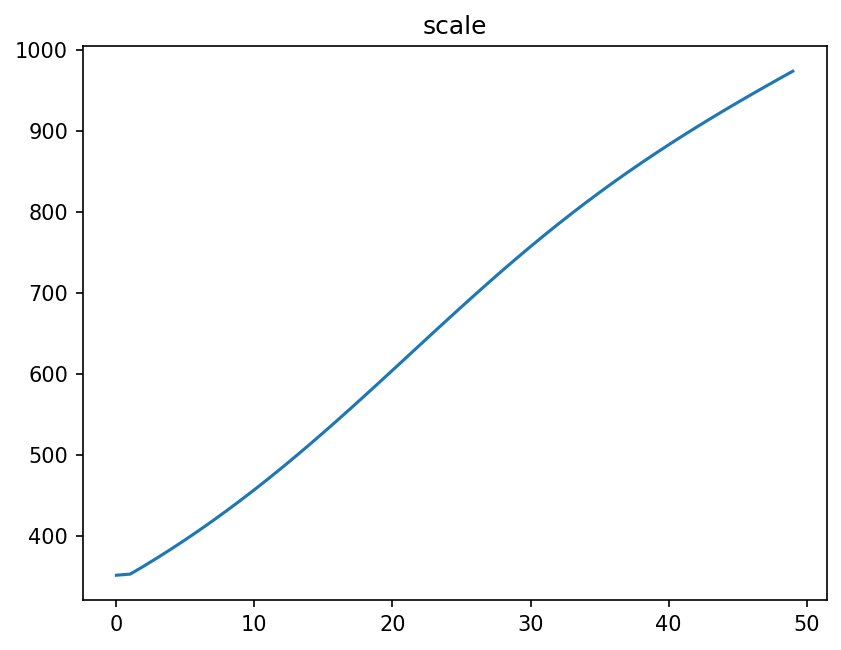

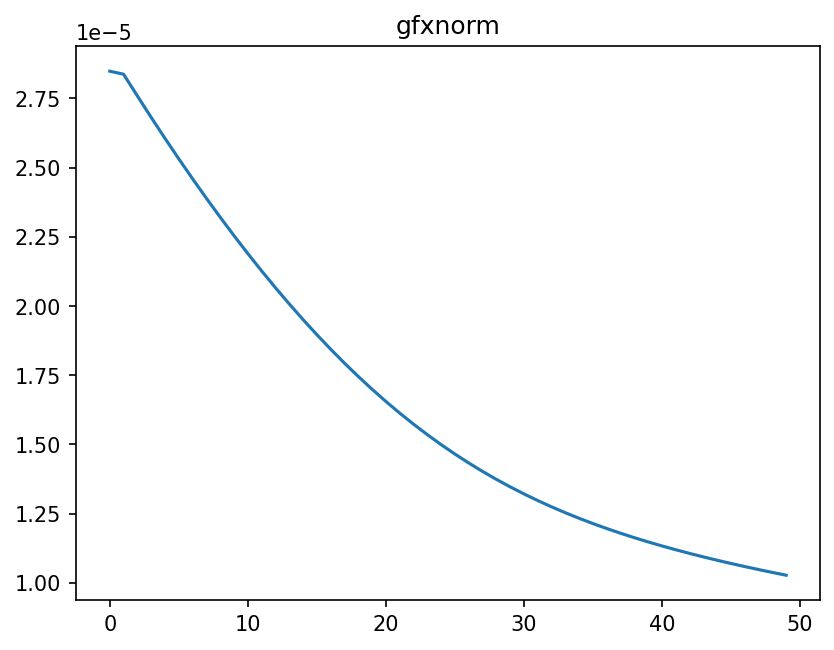

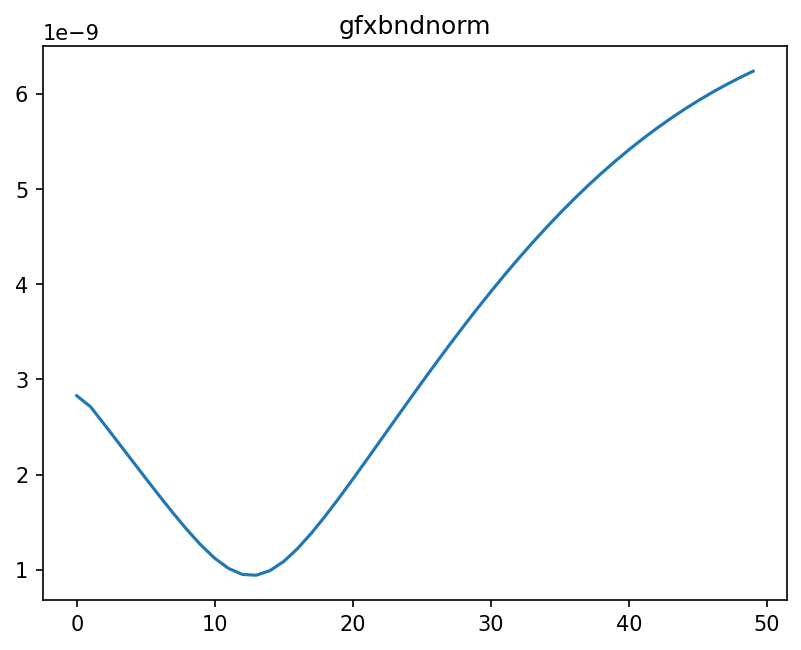

In [18]:
plt.rcParams['figure.dpi'] = 150
c = 0
for e in data:
    plt.figure(c)
    plt.title(titles[c])
    plt.plot(range(len(e)),e)
    c += 1